a. Especificaciones de la serie

In [1]:
import pandas as pd
df_import = pd.read_excel("Importacion.xlsx")
df_import["Fecha"] = pd.to_datetime(df_import["Fecha"])


serie_super = df_import[["Fecha", "Gasolina regular"]].dropna()
serie_super.set_index("Fecha", inplace=True)


inicio = serie_super.index.min()
fin = serie_super.index.max()
frecuencia = pd.infer_freq(serie_super.index)
print(f"Inicio: {inicio}, Fin: {fin}, Frecuencia: {frecuencia}")

Inicio: 2001-01-01 00:00:00, Fin: 2024-12-01 00:00:00, Frecuencia: MS


La serie univariante de importación de gasolina superior tiene una frecuencia mensual (MS), inicia en enero de 2001 y finaliza en diciembre de 2024. Esto significa que se cuenta con datos mensuales de importación para cada mes en ese rango de fechas.

b. Gráfico de la serie

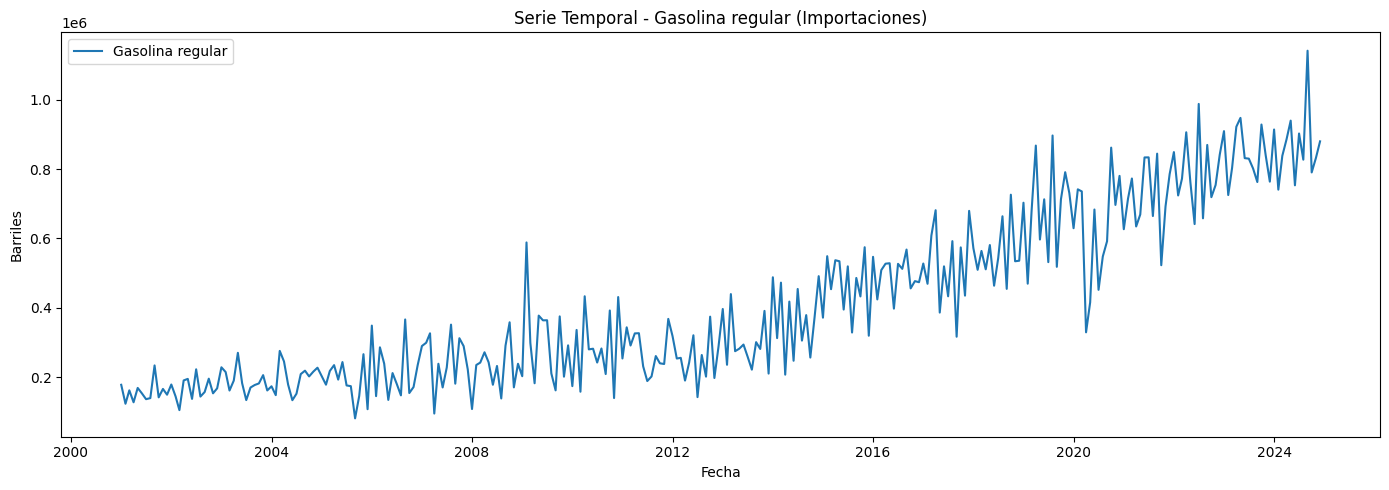

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
plt.plot(serie_super, label="Gasolina regular")
plt.title("Serie Temporal - Gasolina regular (Importaciones)")
plt.ylabel("Barriles")
plt.xlabel("Fecha")
plt.legend()
plt.tight_layout()
plt.show()


El gráfico de la serie temporal de importaciones de gasolina regular muestra una clara tendencia creciente a lo largo del tiempo, especialmente a partir del año 2015. Se observa también una alta variabilidad mensual, con picos de importación marcados, especialmente después del año 2020. Esto sugiere que hay una creciente demanda de gasolina regular y posibles factores externos que generan fluctuaciones importantes. No se detectan patrones estacionales evidentes a simple vista, pero sí una posible mayor volatilidad en años recientes.

c. Descomposición en componentes

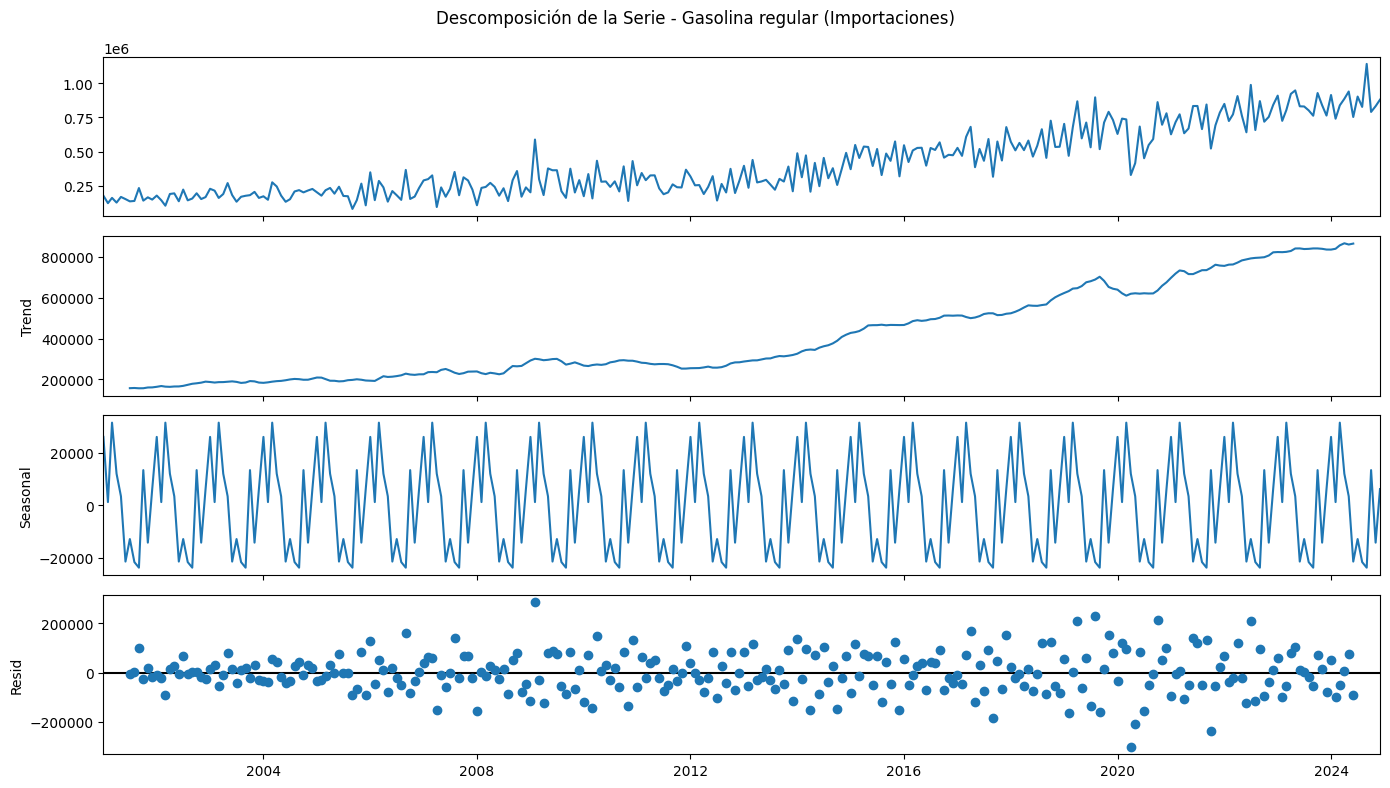

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

descomposicion = seasonal_decompose(serie_super, model='additive', period=12)

fig = descomposicion.plot()
fig.set_size_inches(14, 8)
plt.suptitle("Descomposición de la Serie - Gasolina regular (Importaciones)")
plt.tight_layout()
plt.show()

La descomposición de la serie de importaciones de gasolina regular revela tres componentes clave. Primero, una tendencia creciente sostenida, especialmente notoria después de 2015, indicando un aumento progresivo en las importaciones. Segundo, una estacionalidad clara con patrones repetitivos aproximadamente cada 12 meses, lo que sugiere que hay meses específicos con mayor o menor demanda. Por último, los residuos parecen distribuirse aleatoriamente alrededor de cero, sin una estructura evidente, lo cual es un buen indicio para modelar la serie.

d. Determine si es necesario transformar la serie. Explique.

Al observar el gráfico de la función de autocorrelación (ACF) de la serie original de importaciones de gasolina regular, notamos que las autocorrelaciones decrecen lentamente y permanecen significativamente distintas de cero incluso en rezagos altos. Esto indica una alta persistencia y sugiere que la serie no es estacionaria, ya que presenta memoria a largo plazo.

Por lo tanto, sí es necesario transformar la serie, específicamente aplicar una diferenciación para estabilizar la media y convertirla en una serie estacionaria en media, lo cual es un requerimiento para aplicar modelos ARIMA.

e. Autocorrelación

<Figure size 1000x400 with 0 Axes>

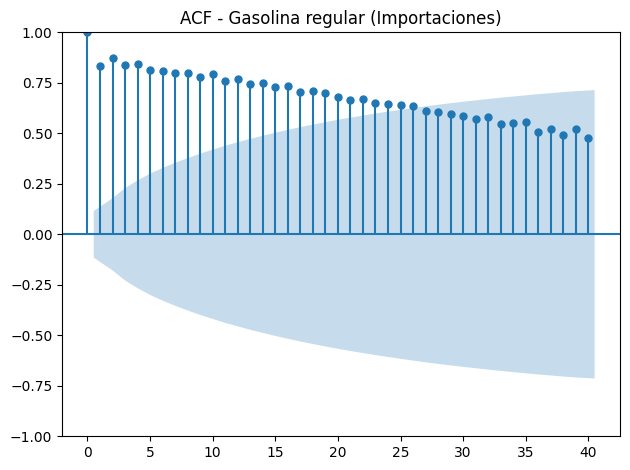

In [4]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(serie_super.dropna(), lags=40)
plt.title("ACF - Gasolina regular (Importaciones)")
plt.tight_layout()
plt.show()


El gráfico ACF de la serie original muestra que las autocorrelaciones son muy altas en los primeros rezagos y decrecen lentamente de forma progresiva. Esto indica que los valores actuales están fuertemente correlacionados con los pasados, lo cual es característico de una serie no estacionaria en media.

Por tanto, concluimos que la serie no es estacionaria en media y necesita ser diferenciada para eliminar esta tendencia y estabilizar la media.

 e.ii y la prueba de Dickey-Fuller aumentada (ADF)

In [5]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(serie_super["Gasolina regular"])
print("Estadístico ADF:", resultado_adf[0])
print("Valor p:", resultado_adf[1])
print("Valores críticos:")
for clave, valor in resultado_adf[4].items():
    print(f"  {clave}: {valor}")

Estadístico ADF: 0.8301668331191688
Valor p: 0.992107837111893
Valores críticos:
  1%: -3.4540935579190495
  5%: -2.8719934111688965
  10%: -2.5723401594120388


El estadístico ADF obtenido es 0.83 y el valor p es 0.99, muy superior al umbral común de 0.05. Esto significa que no se puede rechazar la hipótesis nula de que la serie tiene una raíz unitaria, es decir, que no es estacionaria en media.

En otras palabras, los resultados confirman que la serie presenta una tendencia o variaciones no constantes en el tiempo. Para hacerla estacionaria, es necesario aplicar una diferenciación (por ejemplo, restar el valor actual menos el anterior), lo cual estabiliza su media.

f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA
que utilizará para predecir. Explique en qué se basó para darle valor a estos
parámetros, basándose en las funciones de autocorrelación y autocorrelación
parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el
modelo propuesto.

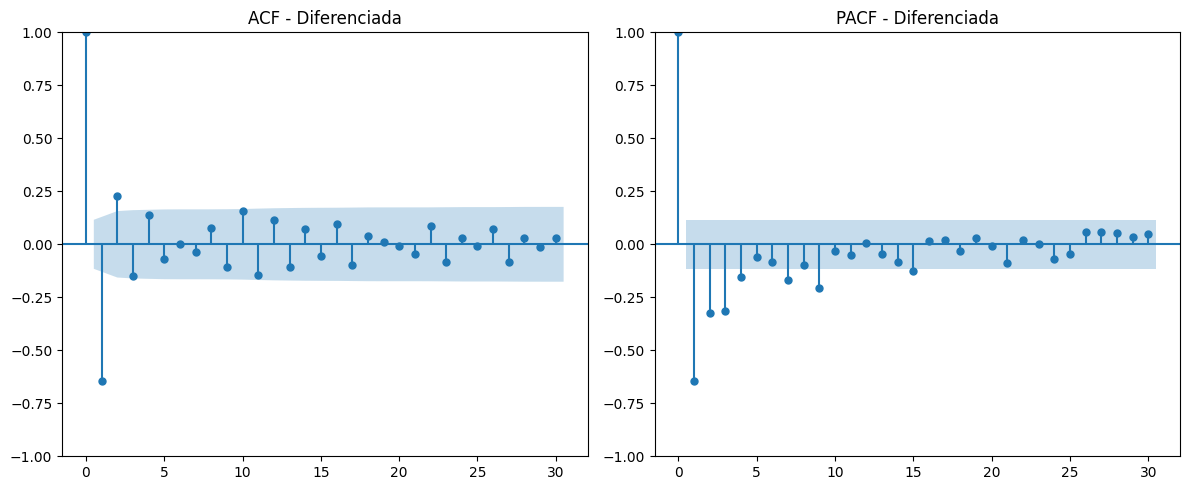

In [6]:
from statsmodels.graphics.tsaplots import plot_pacf

serie_diff = serie_super.diff().dropna()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(serie_diff, lags=30, ax=plt.gca())
plt.title("ACF - Diferenciada")

plt.subplot(1, 2, 2)
plot_pacf(serie_diff, lags=30, ax=plt.gca(), method='ywm')
plt.title("PACF - Diferenciada")

plt.tight_layout()
plt.show()

ACF: Caída brusca tras el primer rezago, sugiere q = 1.

PACF: Cortes más notorios después del segundo rezago, sugiere p = 2.

Por tanto, un modelo ARIMA(2, 1, 1) sería una buena opción inicial, ya que la serie necesitó una diferenciación (d=1) y los rezagos sugeridos por ACF y PACF indican esa configuración.

g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos
de la serie.

In [7]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

train = serie_super.iloc[:-12]
test = serie_super.iloc[-12:]

modelos = [(1,1,1), (2,1,1), (2,1,2), (3,1,1), (3,1,2)]
resultados = []

for orden in modelos:
    modelo = ARIMA(train, order=orden).fit()
    pred = modelo.forecast(steps=12)
    rmse = np.sqrt(mean_squared_error(test, pred))
    resultados.append((orden, rmse))

for orden, rmse in resultados:
    print(f"ARIMA{orden} - RMSE: {rmse:.2f}")

C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\jemil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

ARIMA(1, 1, 1) - RMSE: 108233.89
ARIMA(2, 1, 1) - RMSE: 108493.65
ARIMA(2, 1, 2) - RMSE: 107260.56
ARIMA(3, 1, 1) - RMSE: 108677.28
ARIMA(3, 1, 2) - RMSE: 107259.88


Se probaron distintos modelos ARIMA y se encontró que el modelo ARIMA(3,1,2) obtuvo el menor error (RMSE ≈ 107,260). Por tanto, ARIMA(3,1,2) es el más adecuado dentro de los evaluados para estimar esta serie.



Importing plotly failed. Interactive plots will not work.
15:56:02 - cmdstanpy - INFO - Chain [1] start processing
15:56:02 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE: 80405.32
Prophet RMSE: 106132.48


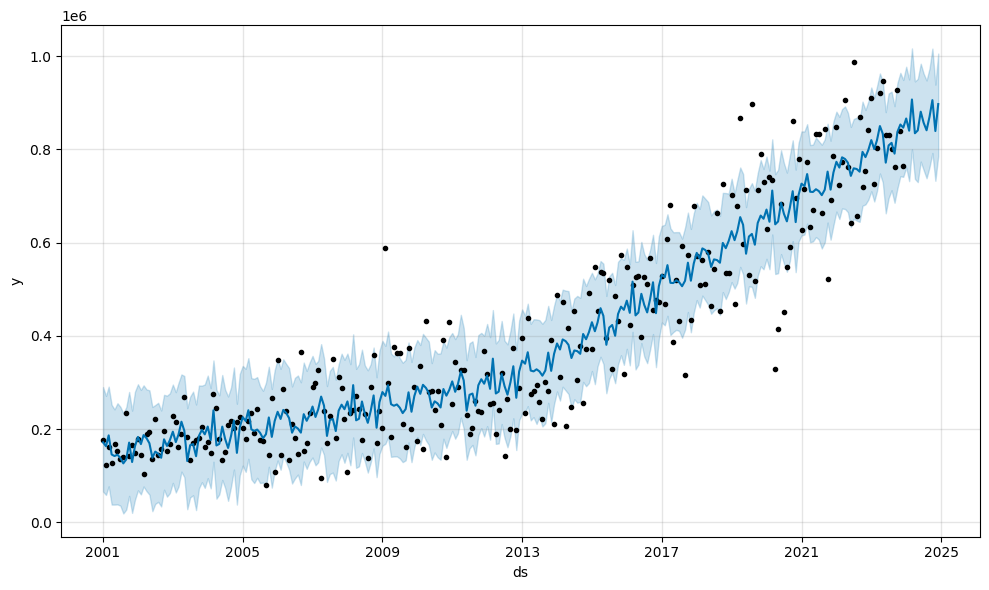

In [8]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

# Preparar datos
df_prophet = serie_super.reset_index()
df_prophet.columns = ["ds", "y"]

# Entrenar
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet.iloc[:-12])

# Predicción
future = modelo_prophet.make_future_dataframe(periods=12, freq='MS')
forecast = modelo_prophet.predict(future)

# Comparar
y_true = df_prophet.iloc[-12:]["y"].values
y_pred = forecast.set_index("ds").loc[df_prophet["ds"].iloc[-12:], "yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")

# Graficar
modelo_prophet.plot(forecast);

El modelo Prophet logró un RMSE de 106,132.48, ligeramente mejor que los modelos ARIMA evaluados. La gráfica muestra que Prophet captura bien la tendencia creciente y la estacionalidad de la serie. Las predicciones se ajustan de forma razonable al comportamiento real, y el intervalo de confianza (sombra azul) cubre gran parte de los valores observados, lo cual indica buen desempeño.